# <div align='center' style='font-size:30px;color:#336699;'>Image Scaling Attack on Machine Learning Algorithms: A Cyber Security Perspective 💻</div>

Install required libraries.

In [1]:
!pip install tensorflow-constrained-optimization
!pip install opencv-python
!pip install opencv-contrib-python
!pip install pillow
!pip install tensorflow-gpu==2.12.0

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [44 lines of output]
  Traceback (most recent call last):
    File "C:\Users\wania\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
      parsed = _parse_requirement(requirement_string)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\wania\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
      return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\wania\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
      url, specifier, marker = _parse_requirement_details(tokenizer)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\wania\anaconda3\Lib\site-packages\setuptools\_v


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


Import the required libraries.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_constrained_optimization as tfco
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import cv2
import numpy as np
import argparse
from pathlib import Path
import os
import sys
import random
from PIL import Image
from keras.applications.resnet50 import preprocess_input
#import utils
import time

# tensorflow-gpu == 2.12.0


### Functionality and Optimization of Image Scaling Attack

In [3]:
class Problem(tfco.ConstrainedMinimizationProblem):
    def __init__(self, S, T, method, epsilon):
        self._delta = tf.Variable(tf.expand_dims(tf.ones(shape=S.shape, dtype=tf.float32), axis=0), trainable=True, name="delta")
        self._S = tf.expand_dims(tf.convert_to_tensor(S, dtype=tf.float32) / 255, axis=0)
        self._T = tf.expand_dims(tf.convert_to_tensor(T, dtype=tf.float32) / 255, axis=0)
        self._method = method
        self._epsilon = epsilon
        self._delta_shape = self._S.shape
        self._main_constraint = 0
        self._n_constraints = self._T.shape[0] * self._T.shape[1] * self._T.shape[2] * self._T.shape[3] * 2 + 1

    @property
    def num_constraints(self):
        return self._n_constraints

    def objective(self):
        return tf.norm(self._delta, ord='euclidean')

    def constraints(self):
        D = tf.image.resize(self._S + self._delta, size=[self._T.shape[1], self._T.shape[2]], method=self._method)
        main_contraint = tf.norm((D - self._T), ord='euclidean') - self._epsilon
        self._main_constraint = main_contraint
        main_contraint = tf.reshape(main_contraint, shape=(1,1))
        gt_or_eq_to_zero= tf.reshape(-D, shape=(D.shape[0] * D.shape[1] * D.shape[2] * D.shape[3], 1))
        lt_or_eq_to_1= tf.reshape(D - 1, shape=(D.shape[0] * D.shape[1] * D.shape[2] * D.shape[3], 1))

        constraints = tf.concat([main_contraint, gt_or_eq_to_zero, lt_or_eq_to_1], axis=0)
        constraints = tf.reshape(constraints, shape=(constraints.shape[0]))
        return constraints
        
def optimize(S, T, method, epsilon, iterations):
    problem = Problem(S, T, method, epsilon)
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            loss = problem.objective()
            constraints = problem.constraints()
            
            # Adding a term to the loss for any constraints that are violated.
            loss += tf.reduce_sum(tf.nn.relu(constraints))

        gradients = tape.gradient(loss, [problem._delta])
        optimizer.apply_gradients(zip(gradients, [problem._delta]))

        if i % 1000 == 0:
            print(f'[*] Step = {i}')
            print("\t\t[*] Modification size: ", problem.objective().numpy())
            print("\t\t[*] Difference between the modified image (A) and target image: ", problem._main_constraint.numpy())

    # Modified image
    A = problem._S[0] + problem._delta[0]
    return A

Select any source image *(S)* and a target image *(T)* for the attack.

In [23]:
# Source image (S)
source_path = 'C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pics/70.png'
# Target image (T)
target_path = 'C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pictures/124124.png'

In [24]:
def show_image(image_path):
    img = image.load_img(image_path)
    img_tensor = image.img_to_array(img)
    img_tensor /= 255
    plt.imshow(img_tensor)
    print(img_tensor.shape)

(889, 1400, 3)


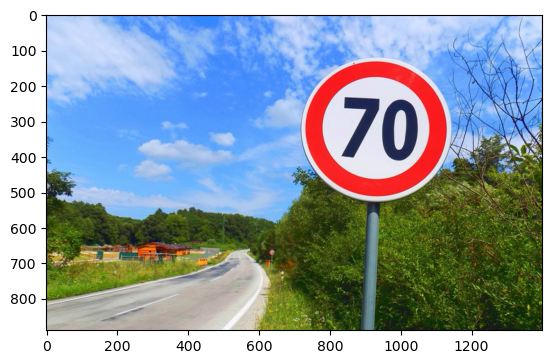

In [25]:
# Source image (S)
show_image(source_path)

(54, 54, 3)


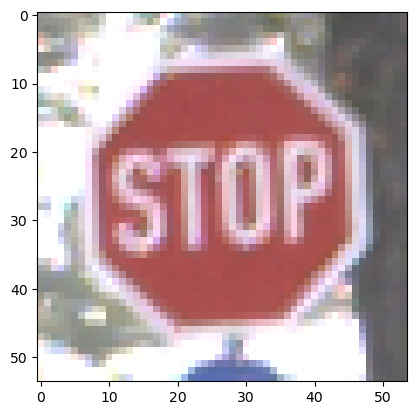

In [26]:
# Target image (T)
show_image(target_path)

In [27]:
def load_image(tam):
    img = image.load_img(source_path, target_size=(tam, tam))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    return img_tensor

### Attack Modes
* #### Attack mode 1:

     Checks if the test image classifies under the given false classification label.

* #### Attack mode 2:

     Checks if the test image classifies under any label except the given correct classification label.

### Attack Attempt using Interpolations

Finds the image size of the ML model for German Traffic Sign Recognition Benchmark (GTSRB), and attempts an image scaling attack to check vulnerable interpolation techniques.

Attacking the model... trying to find out the size of model inputs...

1/1 [==============================] - 0s 109ms/step
--- The shape of their model inputs is (30, 30, 3) --- 

Now checking interpolation method...

CHOICE ---> bilinear

[*] Step = 0
		[*] Modification size:  1931.7217
		[*] Difference between the modified image (A) and target image:  50.3755
[*] Step = 1000
		[*] Modification size:  1614.0558
		[*] Difference between the modified image (A) and target image:  0.25126746
[*] Step = 2000
		[*] Modification size:  1298.6553
		[*] Difference between the modified image (A) and target image:  3.4168363e-05
[*] Step = 3000
		[*] Modification size:  983.782
		[*] Difference between the modified image (A) and target image:  -0.029886216


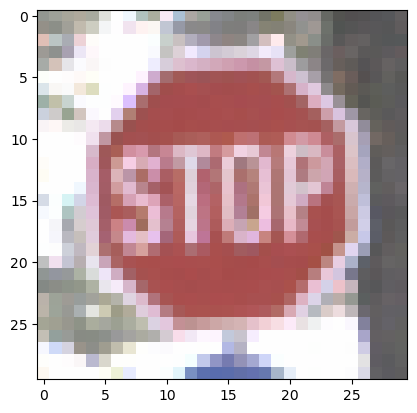

1/1 [==============================] - 0s 25ms/step

This is a Stop signal.

-----------------

CHOICE ---> lanczos3

[*] Step = 0
		[*] Modification size:  1931.8304
		[*] Difference between the modified image (A) and target image:  50.40986
[*] Step = 1000
		[*] Modification size:  1616.8109
		[*] Difference between the modified image (A) and target image:  0.03486436
[*] Step = 2000
		[*] Modification size:  1301.9932
		[*] Difference between the modified image (A) and target image:  0.019483216
[*] Step = 3000
		[*] Modification size:  987.8169
		[*] Difference between the modified image (A) and target image:  -0.0073817894


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


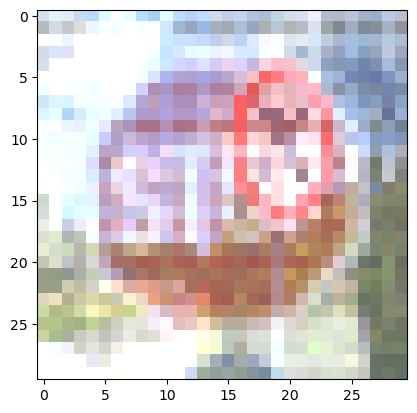

1/1 [==============================] - 0s 31ms/step

This is a Stop signal.

-----------------

CHOICE ---> lanczos5

[*] Step = 0
		[*] Modification size:  1931.8383
		[*] Difference between the modified image (A) and target image:  50.42319
[*] Step = 1000
		[*] Modification size:  1617.0052
		[*] Difference between the modified image (A) and target image:  0.027854823
[*] Step = 2000
		[*] Modification size:  1302.4526
		[*] Difference between the modified image (A) and target image:  0.027074747
[*] Step = 3000
		[*] Modification size:  988.6252
		[*] Difference between the modified image (A) and target image:  -0.004104525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


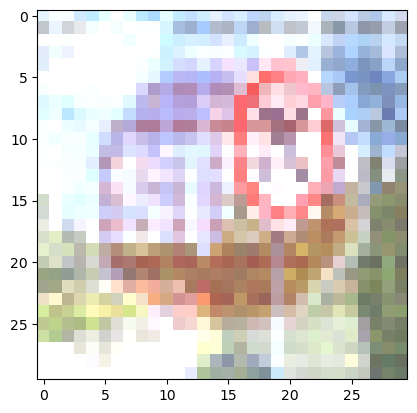

1/1 [==============================] - 0s 36ms/step

This is a Veh > 3.5 tons prohibited signal.

-----------------

CHOICE ---> bicubic

[*] Step = 0
		[*] Modification size:  1931.7966
		[*] Difference between the modified image (A) and target image:  50.397934
[*] Step = 1000
		[*] Modification size:  1616.1713
		[*] Difference between the modified image (A) and target image:  -0.012623623
[*] Step = 2000
		[*] Modification size:  1300.9491
		[*] Difference between the modified image (A) and target image:  0.004381232
[*] Step = 3000
		[*] Modification size:  986.24384
		[*] Difference between the modified image (A) and target image:  -0.00062663853


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


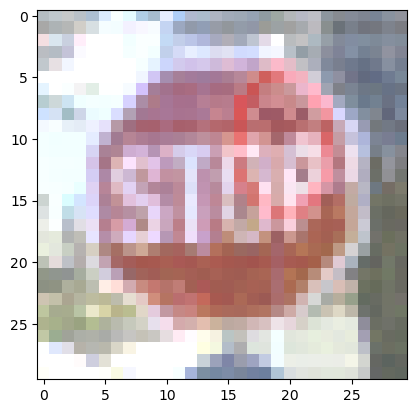

1/1 [==============================] - 0s 31ms/step

This is a Keep left signal.

-----------------

CHOICE ---> gaussian

[*] Step = 0
		[*] Modification size:  1931.6802
		[*] Difference between the modified image (A) and target image:  50.363567
[*] Step = 1000
		[*] Modification size:  1613.0768
		[*] Difference between the modified image (A) and target image:  1.7786561
[*] Step = 2000
		[*] Modification size:  1297.7711
		[*] Difference between the modified image (A) and target image:  -0.026571296
[*] Step = 3000
		[*] Modification size:  983.00354
		[*] Difference between the modified image (A) and target image:  -0.006373085


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


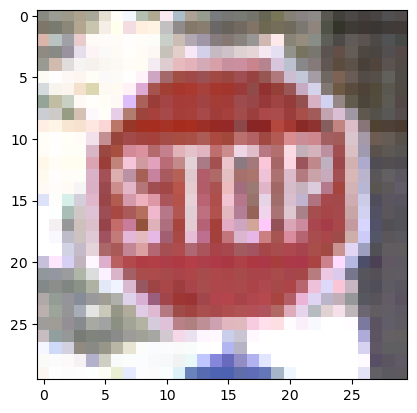

1/1 [==============================] - 0s 16ms/step

This is a Go straight or left signal.

-----------------

CHOICE ---> nearest

[*] Step = 0
		[*] Modification size:  1931.8655
		[*] Difference between the modified image (A) and target image:  50.428684
[*] Step = 1000
		[*] Modification size:  1615.4331
		[*] Difference between the modified image (A) and target image:  -0.02101262
[*] Step = 2000
		[*] Modification size:  1299.9032
		[*] Difference between the modified image (A) and target image:  -0.01189176
[*] Step = 3000
		[*] Modification size:  984.8373
		[*] Difference between the modified image (A) and target image:  0.0006264001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


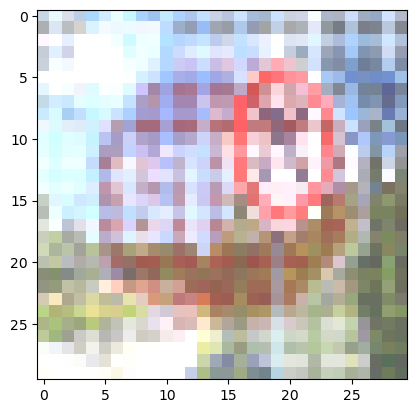

1/1 [==============================] - 0s 49ms/step

This is a Dangerous curve left signal.

-----------------

CHOICE ---> mitchellcubic

[*] Step = 0
		[*] Modification size:  1931.7357
		[*] Difference between the modified image (A) and target image:  50.381565
[*] Step = 1000
		[*] Modification size:  1614.8354
		[*] Difference between the modified image (A) and target image:  -0.0041712075
[*] Step = 2000
		[*] Modification size:  1299.4574
		[*] Difference between the modified image (A) and target image:  -0.0229695
[*] Step = 3000
		[*] Modification size:  984.60175
		[*] Difference between the modified image (A) and target image:  -0.02123575


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


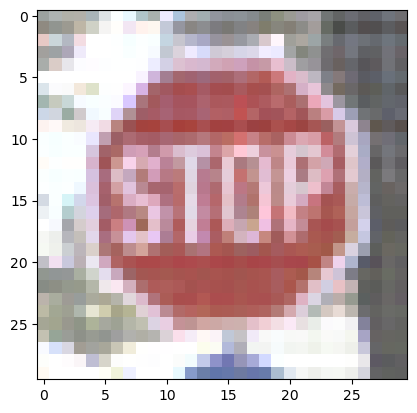

1/1 [==============================] - 0s 30ms/step

This is a Stop signal.

-----------------



In [28]:
print("Attacking the model... trying to find out the size of model inputs...\n")

for size in range(1, 2000):
    model = tf.keras.models.load_model('C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/GTSRB model.keras')
    image_tensor = load_image(size)

    try:
        preds = model.predict(image_tensor)
    except:
        continue

    break

attack_shape = image_tensor.shape[1:]
print(f"--- The shape of their model inputs is {attack_shape} --- \n")
print("Now checking interpolation method...\n")

S = cv2.cvtColor(cv2.imread(source_path, 1), cv2.COLOR_BGR2RGB)
T = cv2.cvtColor(cv2.imread(target_path, 1), cv2.COLOR_BGR2RGB)
T = cv2.resize(T, (attack_shape[0], attack_shape[1]))

choices = ['bilinear', 'lanczos3', 'lanczos5', 'bicubic', 'gaussian', 'nearest','mitchellcubic']
chosen = []
class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

for choice in choices:
    print(f"CHOICE ---> {choice}\n")
    A = optimize(S, T, choice, 0.1, 4000)
    D = tf.image.resize(tf.expand_dims(A, axis=0), size=[T.shape[0], T.shape[1]])[0]

    D_expanded = np.expand_dims(D, axis=0)
    D_expanded = D_expanded * 255
    D_expanded = D_expanded.astype(np.uint8) / 1

    plt.imshow(D)
    plt.show()

    prediction = model.predict(D_expanded)
    prediction = np.argmax(prediction)

    print()
    print(f"This is a {class_names[prediction]} signal.\n")

    if class_names[prediction] == 'Stop': chosen.append(choice)

    print("-----------------\n")

### Vulnerable Interpolations

In [29]:
print(f"The model is vulnerable to size {attack_shape} and methods of interpolation {chosen}")

The model is vulnerable to size (30, 30, 3) and methods of interpolation ['bilinear', 'lanczos3', 'mitchellcubic']


### Utilis

In [79]:
def imgLoader(imgPath, color_flag=cv2.IMREAD_COLOR):
    try:
        img = cv2.imread(imgPath, color_flag)
        if img is None:
            raise FileNotFoundError(f"Fail to load the image {imgPath}")
        height, width, *channel = img.shape
        if not channel:
            img = img.reshape((height, width, 1))
        return img
    except Exception as e:
        print(e)
        return None

def imgSaver(imgPath, img):
    try:
        cv2.imwrite(imgPath, img)
    except:
        print(f'Fail to save the image as {imgPath}')

def color_shift(sourceImg, targetImg):
    source = cv2.resize(sourceImg, (targetImg.shape[1], targetImg.shape[0]))
    source_hsv = cv2.cvtColor(source, cv2.COLOR_BGR2HSV)
    target_hsv = cv2.cvtColor(targetImg, cv2.COLOR_BGR2HSV)
    target_hsv[:, :, 0:2] = source_hsv[:, :, 0:2]
    target_shifted = cv2.cvtColor(target_hsv, cv2.COLOR_HSV2BGR)
    return target_shifted

def darknet_resize(img, outShape):
    w, h = outShape
    if len(img.shape) == 2:
        img = np.reshape(img, (img.shape[0], img.shape[1],1))
    img_h, img_w, img_c = img.shape
    w_scale = (img_w - 1.0) / (w - 1.0)
    h_scale = (img_h - 1.0) / (h - 1.0)
    new_img = np.zeros((h,w,img_c))
    part = np.zeros((img_h,w,img_c))
    for k in range(img_c):
        for r in range(img_h):
            for c in range(w):
                val = 0
                if c == w-1 or img_w == 1:
                    val = img[r, img_w-1, k]
                else:
                    sx = c * w_scale
                    ix = int(sx)
                    dx = 1.0 * (sx - ix)
                    val = (1-dx) * img[r,ix,k] + dx * img[r,ix+1,k]
                part[r,c,k] = val

    for k in range(img_c):
        for r in range(h):
            sy = r*h_scale
            iy = int(sy)
            dy = 1.0 * (sy-iy)
            for c in range(w):
                val = (1-dy) * part[iy,c,k]
                new_img[r,c,k] = val
            if r == h-1 or img_h == 1:
                continue
            for c in range(w):
                val = dy * part[iy+1,c,k]
                new_img[r,c,k] = new_img[r,c,k] + val
    new_img = np.uint8(new_img)
    return new_img

### L0, L2, LI Norms

In [80]:
class ScalingCamouflageGPU(object):
    def __init__(self, sourceImg=None, targetImg=None, norm='l2', **kwargs):
        _, __, *channel = sourceImg.shape
        if not channel:
            self.sourceImg = sourceImg[:, :, np.newaxis]
        else:
            self.sourceImg = sourceImg
        _, __, *channel = targetImg.shape
        if not channel:
            self.targetImg = targetImg[:, :, np.newaxis]
        else:
            self.targetImg = targetImg
        self.params = {'func': cv2.resize,
                       'interpolation': cv2.INTER_LINEAR,
                       'norm': norm,
                       'penalty': 1.,
                       'img_factor': 255.}
        keys = self.params.keys()
        for key, value in kwargs.items():
            assert key in keys, ('Improper parameter %s, '
                                 'The parameter should in: '
                                 '%s' % (key, keys))
            self.params[key] = value

    def setResizeMethod(self, func=cv2.resize, interpolation=cv2.INTER_NEAREST):
        self.params['func'] = func
        self.params['interpolation'] = interpolation

    def setSourceImg(self, sourceImg):
        _, __, *channel = sourceImg.shape
        if not channel:
            self.sourceImg = sourceImg[:, :, np.newaxis]
        else:
            self.sourceImg = sourceImg

    def setTargetImg(self, targetImg):
        _, __, *channel = targetImg.shape
        if not channel:
            self.targetImg = targetImg[:, :, np.newaxis]
        else:
            self.targetImg = targetImg

    def estimateConvertMatrix(self, inSize, outSize):
        inputDummyImg = (self.params['img_factor'] *
                         np.eye(inSize)).astype('uint8')
        outputDummyImg = self._resize(inputDummyImg,
                                      outShape=(inSize, outSize))
        convertMatrix = (outputDummyImg[:, :, 0] /
                         (np.sum(outputDummyImg[:, :, 0], axis=1)).reshape(outSize, 1))
        return convertMatrix

    def _resize(self, inputImg, outShape=(0, 0)):
        func = self.params['func']
        interpolation = self.params['interpolation']

        if func is Image.Image.resize:
            inputImg = Image.fromarray(inputImg)
        if func is cv2.resize:
            outputImg = func(inputImg, outShape, interpolation=interpolation)
        else:
            outputImg = func(inputImg, outShape, interpolation)
            outputImg = np.array(outputImg)
        if len(outputImg.shape) == 2:
            outputImg = outputImg[:, :, np.newaxis]
        return np.array(outputImg)

    def _getPerturbationGPU_l2(self, convertMatrixL, convertMatrixR, source, target):
        penalty_factor = self.params['penalty']
        p, q, c = source.shape
        a, b, c = target.shape
        convertMatrixL = tf.constant(convertMatrixL, dtype=tf.float32)
        convertMatrixR = tf.constant(convertMatrixR, dtype=tf.float32)
        modifier_init = np.zeros(source.shape)
        source = tf.constant(source, dtype=tf.float32)
        target = tf.constant(target, dtype=tf.float32)
        modifier = tf.Variable(modifier_init, dtype=tf.float32)
        attack = (tf.tanh(modifier) + 1) * 0.5
        x = tf.reshape(attack, [p, -1])
        x = tf.matmul(convertMatrixL, x)
        x = tf.reshape(x, [-1, q, c])
        x = tf.transpose(x, [1, 0, 2])
        x = tf.reshape(x, [q, -1])
        x = tf.matmul(convertMatrixR, x)
        x = tf.reshape(x, [-1, a, c])
        output = tf.transpose(x, [1, 0, 2])
        delta_1 = attack - source
        delta_2 = output - target
        obj1 = tf.reduce_sum(tf.square(delta_1)) / (p * q)
        obj2 = penalty_factor * tf.reduce_sum(tf.square(delta_2)) / (a * b)
        obj = obj1 + obj2
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.1) 
        for i in range(200):  
            with tf.GradientTape() as tape:
                tape.watch(modifier)
                attack = (tf.tanh(modifier) + 1) * 0.5
                x = tf.reshape(attack, [p, -1])
                x = tf.matmul(convertMatrixL, x)
                x = tf.reshape(x, [-1, q, c])
                x = tf.transpose(x, [1, 0, 2])
                x = tf.reshape(x, [q, -1])
                x = tf.matmul(convertMatrixR, x)
                x = tf.reshape(x, [-1, a, c])
                output = tf.transpose(x, [1, 0, 2])
                delta_1 = attack - source
                delta_2 = output - target
                obj1 = tf.reduce_sum(tf.square(delta_1)) / (p * q)
                obj2 = penalty_factor * tf.reduce_sum(tf.square(delta_2)) / (a * b)
                obj = obj1 + obj2
            gradients = tape.gradient(obj, [modifier])
            gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
            optimizer.apply_gradients(zip(gradients, [modifier]))
        attack_opt = attack.numpy()
        return attack_opt

    def _getPerturbationGPU_l0(self, convertMatrixL, convertMatrixR, source, target):
        penalty_factor = self.params['penalty']
        p, q, c = source.shape
        a, b, c = target.shape
        convertMatrixL = tf.constant(convertMatrixL, dtype=tf.float32)
        convertMatrixR = tf.constant(convertMatrixR, dtype=tf.float32)
        modifier_init = np.zeros(source.shape)
        source = tf.constant(source, dtype=tf.float32)
        target = tf.constant(target, dtype=tf.float32)
        modifier = tf.Variable(modifier_init, dtype=tf.float32)
        feasible_area = np.ones(source.shape)
        prev_obj = np.inf
        while True:
            attack = source * (1 - feasible_area) + 0.5 * (tf.tanh(modifier) + 1) * feasible_area
            x = tf.reshape(attack, [p, -1])
            x = tf.matmul(convertMatrixL, x)
            x = tf.reshape(x, [-1, q, c])
            x = tf.transpose(x, [1, 0, 2])
            x = tf.reshape(x, [q, -1])
            x = tf.matmul(convertMatrixR, x)
            x = tf.reshape(x, [-1, a, c])
            output = tf.transpose(x, [1, 0, 2])
            delta_1 = attack - source
            delta_2 = output - target
            obj1 = tf.reduce_sum(tf.square(delta_1)) / (p * q)
            obj2 = penalty_factor * tf.reduce_sum(tf.square(delta_2)) / (a * b)
            obj = obj1 + obj2
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
            with tf.GradientTape() as tape:
                tape.watch(modifier)
                attack = source * (1 - feasible_area) + 0.5 * (tf.tanh(modifier) + 1) * feasible_area
                x = tf.reshape(attack, [p, -1])
                x = tf.matmul(convertMatrixL, x)
                x = tf.reshape(x, [-1, q, c])
                x = tf.transpose(x, [1, 0, 2])
                x = tf.reshape(x, [q, -1])
                x = tf.matmul(convertMatrixR, x)
                x = tf.reshape(x, [-1, a, c])
                output = tf.transpose(x, [1, 0, 2])
                delta_1 = attack - source
                delta_2 = output - target
                obj1 = tf.reduce_sum(tf.square(delta_1)) / (p * q)
                obj2 = penalty_factor * tf.reduce_sum(tf.square(delta_2)) / (a * b)
                obj = obj1 + obj2
            gradients = tape.gradient(obj, [modifier])
            optimizer.apply_gradients(zip(gradients, [modifier]))
            obj_value = obj.numpy()
            if obj_value > 0.999 * prev_obj:
                break
            prev_obj = obj_value
        attack_opt = attack.numpy()
        return attack_opt

    def _getPerturbationGPU_li(self, convertMatrixL, convertMatrixR, source, target):
        penalty_factor = self.params['penalty']
        p, q, c = source.shape
        a, b, c = target.shape
        convertMatrixL = tf.constant(convertMatrixL, dtype=tf.float32)
        convertMatrixR = tf.constant(convertMatrixR, dtype=tf.float32)
        old_modifier = np.arctanh((2 * source - 1) * 0.9999999)
        source = tf.constant(source, dtype=tf.float32)
        target = tf.constant(target, dtype=tf.float32)
        modifier = tf.Variable(np.zeros(source.shape), dtype=tf.float32)
        assign_modifier = tf.Variable(initial_value=modifier)
        set_modifier = assign_modifier.assign
        attack = (tf.tanh(modifier) + 1) * 0.5
        x = tf.reshape(attack, [p, -1])
        x = tf.matmul(convertMatrixL, x)
        x = tf.reshape(x, [-1, q, c])
        x = tf.transpose(x, [1, 0, 2])
        x = tf.reshape(x, [q, -1])
        x = tf.matmul(convertMatrixR, x)
        x = tf.reshape(x, [-1, a, c])
        output = tf.transpose(x, [1, 0, 2])
        tau1 = tf.constant(1.0)
        tau2 = tf.constant(1.0)
        delta1 = attack - source
        delta2 = output - target
        obj1 = tf.reduce_sum(tf.maximum(0.0, (tf.abs(delta1) - tau1))) / (p * q)
        obj2 = penalty_factor * tf.reduce_sum(tf.square(delta2)) / (a * b)
        obj = obj1 + obj2
        max_iteration = 2000
        actualtau1 = np.inf
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        while tau1 > 1. / self.params['img_factor']:
            modifier.assign(old_modifier)
            prev = np.inf
            for i in range(max_iteration):
                with tf.GradientTape() as tape:
                    attack = (tf.tanh(modifier) + 1) * 0.5
                    x = tf.reshape(attack, [p, -1])
                    x = tf.matmul(convertMatrixL, x)
                    x = tf.reshape(x, [-1, q, c])
                    x = tf.transpose(x, [1, 0, 2])
                    x = tf.reshape(x, [q, -1])
                    x = tf.matmul(convertMatrixR, x)
                    x = tf.reshape(x, [-1, a, c])
                    output = tf.transpose(x, [1, 0, 2])
                    delta1 = attack - source
                    delta2 = output - target
                    obj1 = tf.reduce_sum(tf.maximum(0.0, (tf.abs(delta1) - tau1))) / (p * q)
                    obj2 = penalty_factor * tf.reduce_sum(tf.square(delta2)) / (a * b)
                    obj = obj1 + obj2
                gradients = tape.gradient(obj, [modifier])
                optimizer.apply_gradients(zip(gradients, [modifier]))
                obj_value = obj.numpy()
                if obj_value > prev * 0.9999:
                    break
                prev = obj_value
            actualtau1 = np.max(np.abs(delta1.numpy()))
            if actualtau1 < tau1.numpy():
                tau1 = tau1 * 0.9
            else:
                break
        attack_opt = attack.numpy()
        return attack_opt

    def attack(self):
        sourceImg = self.sourceImg
        targetImg = self.targetImg
        sourceHeight, sourceWidth, sourceChannel = sourceImg.shape
        targetHeight, targetWidth, targetChannel = targetImg.shape
        convertMatrixL = self.estimateConvertMatrix(sourceHeight, targetHeight)
        convertMatrixR = self.estimateConvertMatrix(sourceWidth, targetWidth)
        img_factor = self.params['img_factor']
        sourceImg = sourceImg / img_factor
        targetImg = targetImg / img_factor
        source = sourceImg
        target = targetImg
        self.info()
        if self.params['norm'] == 'l2':
            attackImg = self._getPerturbationGPU_l2(convertMatrixL, convertMatrixR, source, target)
        elif self.params['norm'] == 'l0':
            attackImg = self._getPerturbationGPU_l0(convertMatrixL, convertMatrixR, source, target)
        elif self.params['norm'] == 'li':
            attackImg = self._getPerturbationGPU_li(convertMatrixL, convertMatrixR, source, target)
        print(f"Maximum Pixel: {np.max(attackImg)}")
        print(f"Minimum Pixel: {np.min(attackImg)}")
        print('\nATTACK SUCCESSFUL!')
        return np.uint8(attackImg * img_factor)

    def info(self):
        if self.params['func'] is cv2.resize:
            func_name = 'cv2.resize'
            inter_dict = ['cv2.INTER_NEAREST',
                          'cv2.INTER_LINEAR',
                          'cv2.INTER_CUBIC',
                          'cv2.INTER_AREA',
                          'cv2.INTER_LANCZOS4']
            inter_name = inter_dict[self.params['interpolation']]
        elif self.params['func'] is Image.Image.resize:
            func_name = 'PIL.Image.resize'
            inter_dict = ['PIL.Image.NEAREST',
                          'PIL.Image.LANCZOS',
                          'PIL.Image.BILINEAR',
                          'PIL.Image.BICUBIC']
        sourceShape = (self.sourceImg.shape[1],
                       self.sourceImg.shape[0],
                       self.sourceImg.shape[2])
        targetShape = (self.targetImg.shape[1],
                       self.targetImg.shape[0],
                       self.targetImg.shape[2])
        print("\nLet's implement an Image Scaling Attack!")
        print('Source Image Size: %s' % str(sourceShape))
        print('Target Image Size: %s' % str(targetShape))
        print('Resize Method: %s' % func_name)
        print('Interpolation Technique: %s' % inter_name)

### Attack

In [81]:
def main(sourceImgPath, targetImgPath, attackImgPath, outputImgPath="", resizeFunc="cv2.resize", interpolation="cv2.INTER_LINEAR", penalty=1, imageFactor=255., norm='l2'):
    start_time = time.time()
    sourceImg = imgLoader(sourceImgPath, 1)
    targetImg = imgLoader(targetImgPath, 1)
    if sourceImg is None or targetImg is None:
        print("Failed to load one or both images. Exiting...")
        return

    targetImg = color_shift(sourceImg, targetImg)
    func_lookup = {'cv2.resize': cv2.resize, 'Image.Image.resize': Image.Image.resize}
    interpolation_lookup = {'cv2.INTER_NEAREST': cv2.INTER_NEAREST,
                            'cv2.INTER_LINEAR': cv2.INTER_LINEAR,
                            'cv2.INTER_CUBIC': cv2.INTER_CUBIC,
                            'cv2.INTER_AREA': cv2.INTER_AREA,
                            'cv2.INTER_LANCZOS4':cv2.INTER_LANCZOS4,
                            'Image.NEAREST': Image.NEAREST,
                            'Image.LANCZOS': Image.LANCZOS,
                            'Image.BILINEAR': Image.BILINEAR,
                            'Image.BICUBIC': Image.BICUBIC,}

    sc = ScalingCamouflageGPU(
        sourceImg,
        targetImg,
        norm=norm,
        func=func_lookup[resizeFunc],
        interpolation=interpolation_lookup[interpolation],
        penalty=penalty,
        img_factor=imageFactor
    )

    attackImg = sc.attack()
    imgSaver(attackImgPath, attackImg)

    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(attackImg, cv2.COLOR_BGR2RGB))
    plt.title('Attack Image')
    plt.axis('on')
    plt.show()

    if len(outputImgPath) > 0:
        attackImg = imgLoader(attackImgPath, 1)
        outputImg = sc._resize(attackImg, (targetImg.shape[0], targetImg.shape[1]))
        imgSaver(outputImgPath, outputImg)
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(outputImg, cv2.COLOR_BGR2RGB))
        plt.title('Output Image')
        plt.axis('on')
        plt.show()

    time_cost = time.time() - start_time
    print("\nDuration:", time_cost)

Testing


Let's implement an Image Scaling Attack!
Source Image Size: (1400, 889, 3)
Target Image Size: (54, 54, 3)
Resize Method: cv2.resize
Interpolation Technique: cv2.INTER_CUBIC
Maximum Pixel: 0.9928625822067261
Minimum Pixel: 0.014590829610824585

ATTACK SUCCESSFUL!


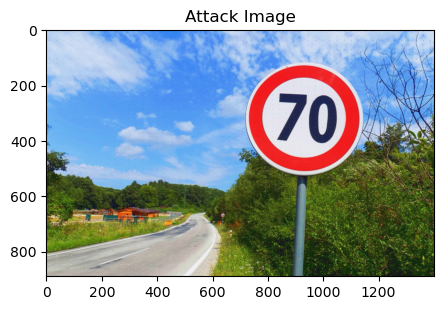

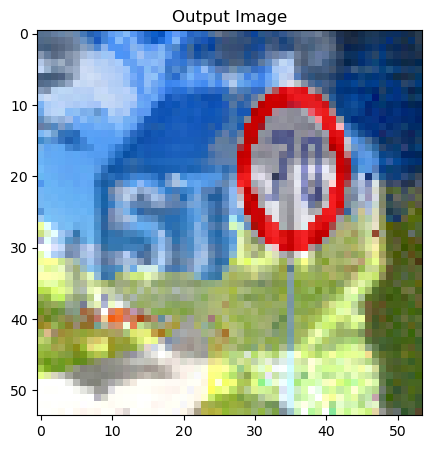


Duration: 33.041568994522095


In [82]:
sourceImgPath = 'C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pics/70.png'
targetImgPath = 'C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pictures/124124.png'
attackImgPath = './attack_l2.jpg'
outputImgPath = './output_l2.jpg'

main(sourceImgPath, targetImgPath, attackImgPath, outputImgPath, 'cv2.resize', 'Image.BILINEAR', 0.1, 255, 'l2')


Let's implement an Image Scaling Attack!
Source Image Size: (1400, 889, 3)
Target Image Size: (54, 54, 3)
Resize Method: cv2.resize
Interpolation Technique: cv2.INTER_CUBIC
Maximum Pixel: 0.9928625822067261
Minimum Pixel: 0.014590829610824585

ATTACK SUCCESSFUL!


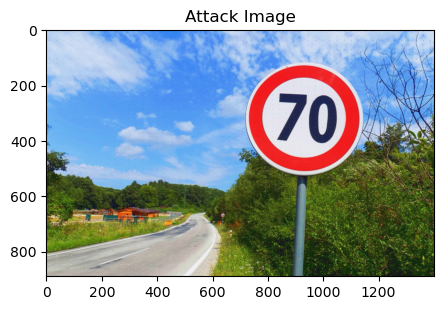

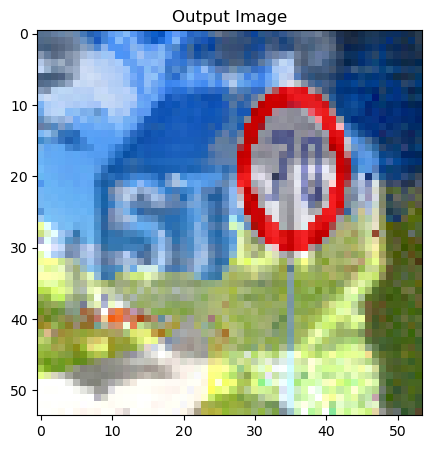


Duration: 31.97875714302063


In [83]:
sourceImgPath = 'C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pics/70.png'
targetImgPath = 'C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pictures/124124.png'
attackImgPath = './attack_l2.jpg'
outputImgPath = './output_l2.jpg'

main(sourceImgPath, targetImgPath, attackImgPath, outputImgPath, 'cv2.resize', 'cv2.INTER_CUBIC', 0.1, 255, 'l2')

### Attack with Classification


Let's implement an Image Scaling Attack!
Source Image Size: (1400, 889, 3)
Target Image Size: (54, 54, 3)
Resize Method: cv2.resize
Interpolation Technique: cv2.INTER_CUBIC
Maximum Pixel: 0.9928625822067261
Minimum Pixel: 0.014590829610824585

ATTACK SUCCESSFUL!


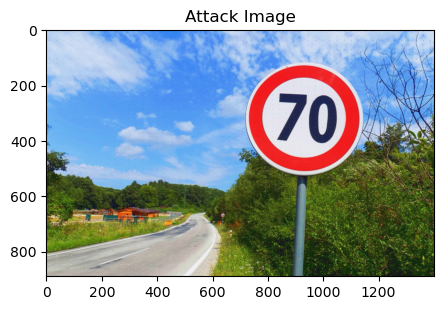

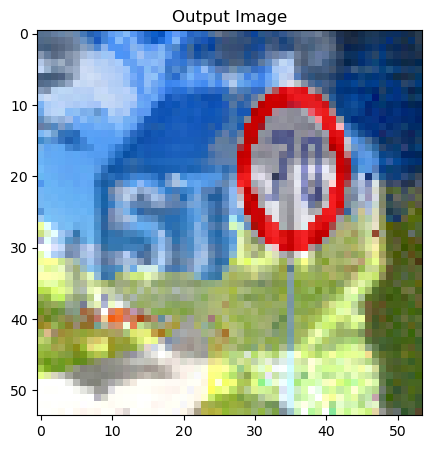

1/1 [==============================] - 0s 358ms/step
The model classifies the Attack Image as class 21 (Double curve).
1/1 [==============================] - 0s 53ms/step
The model classifies the Output Image as class 2 (Speed limit (50km/h)).

Duration: 32.715006828308105


In [93]:
# Ensure model and class_names are defined as per your context
model = tf.keras.models.load_model('C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/GTSRB model.keras')

class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

def main(sourceImgPath, targetImgPath, attackImgPath, outputImgPath="", resizeFunc="cv2.resize", interpolation="cv2.INTER_LINEAR", penalty=1, imageFactor=255., norm='l2'):
    start_time = time.time()
    sourceImg = imgLoader(sourceImgPath, 1)
    targetImg = imgLoader(targetImgPath, 1)
    if sourceImg is None or targetImg is None:
        print("Failed to load one or both images. Exiting...")
        return

    targetImg = color_shift(sourceImg, targetImg)
    func_lookup = {'cv2.resize': cv2.resize, 'Image.Image.resize': Image.Image.resize}
    interpolation_lookup = {'cv2.INTER_NEAREST': cv2.INTER_NEAREST,
                            'cv2.INTER_LINEAR': cv2.INTER_LINEAR,
                            'cv2.INTER_CUBIC': cv2.INTER_CUBIC,
                            'cv2.INTER_AREA': cv2.INTER_AREA,
                            'cv2.INTER_LANCZOS4':cv2.INTER_LANCZOS4,
                            'Image.NEAREST': Image.NEAREST,
                            'Image.LANCZOS': Image.LANCZOS,
                            'Image.BILINEAR': Image.BILINEAR,
                            'Image.BICUBIC': Image.BICUBIC,}

    sc = ScalingCamouflageGPU(
        sourceImg,
        targetImg,
        norm=norm,
        func=func_lookup[resizeFunc],
        interpolation=interpolation_lookup[interpolation],
        penalty=penalty,
        img_factor=imageFactor
    )

    attackImg = sc.attack()
    imgSaver(attackImgPath, attackImg)

    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(attackImg, cv2.COLOR_BGR2RGB))
    plt.title('Attack Image')
    plt.axis('on')
    plt.show()

    if len(outputImgPath) > 0:
        attackImg = imgLoader(attackImgPath, 1)
        outputImg = sc._resize(attackImg, (targetImg.shape[0], targetImg.shape[1]))
        imgSaver(outputImgPath, outputImg)
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(outputImg, cv2.COLOR_BGR2RGB))
        plt.title('Output Image')
        plt.axis('on')
        plt.show()

        # Check classification of the attack and output images
        for img_path, img_type in [(attackImgPath, "Attack Image"), (outputImgPath, "Output Image")]:
            processed_img = preprocess_image(img_path, target_size=(model.input_shape[1], model.input_shape[2]))
            prediction = model.predict(processed_img)
            predicted_class = np.argmax(prediction)
            print(f"The model classifies the {img_type} as class {predicted_class} ({class_names[predicted_class]}).")

    time_cost = time.time() - start_time
    print("\nDuration:", time_cost)

# Testing
sourceImgPath = 'C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pics/70.png'
targetImgPath = 'C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pictures/124124.png'
attackImgPath = 'attack_12.jpg'
outputImgPath = 'output_12.jpg'

main(sourceImgPath, targetImgPath, attackImgPath, outputImgPath, 'cv2.resize', 'cv2.INTER_CUBIC', 0.1, 255, 'l2')


Let's implement an Image Scaling Attack!
Source Image Size: (1400, 889, 3)
Target Image Size: (54, 54, 3)
Resize Method: cv2.resize
Interpolation Technique: cv2.INTER_CUBIC
Maximum Pixel: 0.9928625822067261
Minimum Pixel: 0.014590829610824585

ATTACK SUCCESSFUL!


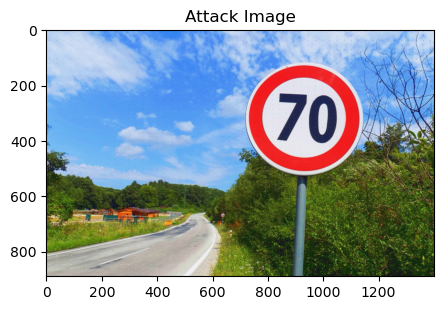

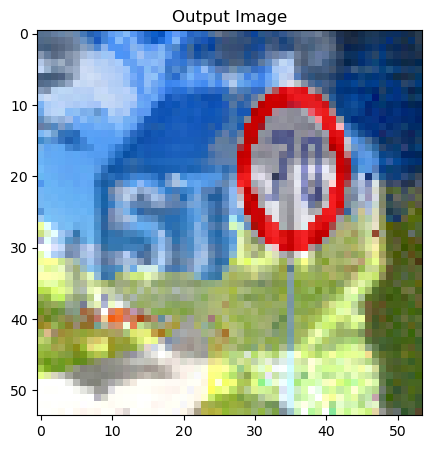

1/1 [==============================] - 0s 39ms/step
The model classifies the Attack Image as class 21 (Double curve).
1/1 [==============================] - 0s 58ms/step
The model classifies the Output Image as class 2 (Speed limit (50km/h)).

Duration: 33.219213247299194


In [94]:
def main(sourceImgPath, targetImgPath, attackImgPath, outputImgPath="", resizeFunc="cv2.resize", interpolation="cv2.INTER_LINEAR", penalty=1, imageFactor=255., norm='l2'):
    start_time = time.time()
    sourceImg = imgLoader(sourceImgPath, 1)
    targetImg = imgLoader(targetImgPath, 1)
    if sourceImg is None or targetImg is None:
        print("Failed to load one or both images. Exiting...")
        return

    targetImg = color_shift(sourceImg, targetImg)
    func_lookup = {'cv2.resize': cv2.resize, 'Image.Image.resize': Image.Image.resize}
    interpolation_lookup = {'cv2.INTER_NEAREST': cv2.INTER_NEAREST,
                            'cv2.INTER_LINEAR': cv2.INTER_LINEAR,
                            'cv2.INTER_CUBIC': cv2.INTER_CUBIC,
                            'cv2.INTER_AREA': cv2.INTER_AREA,
                            'cv2.INTER_LANCZOS4':cv2.INTER_LANCZOS4,
                            'Image.NEAREST': Image.NEAREST,
                            'Image.LANCZOS': Image.LANCZOS,
                            'Image.BILINEAR': Image.BILINEAR,
                            'Image.BICUBIC': Image.BICUBIC,}

    sc = ScalingCamouflageGPU(
        sourceImg,
        targetImg,
        norm=norm,
        func=func_lookup[resizeFunc],
        interpolation=interpolation_lookup[interpolation],
        penalty=penalty,
        img_factor=imageFactor
    )

    attackImg = sc.attack()
    imgSaver(attackImgPath, attackImg)

    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(attackImg, cv2.COLOR_BGR2RGB))
    plt.title('Attack Image')
    plt.axis('on')
    plt.show()

    if len(outputImgPath) > 0:
        attackImg = imgLoader(attackImgPath, 1)
        outputImg = sc._resize(attackImg, (targetImg.shape[0], targetImg.shape[1]))
        imgSaver(outputImgPath, outputImg)
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(outputImg, cv2.COLOR_BGR2RGB))
        plt.title('Output Image')
        plt.axis('on')
        plt.show()

        # Check classification of the attack and output images
        for img_path, img_type in [(attackImgPath, "Attack Image"), (outputImgPath, "Output Image")]:
            processed_img = preprocess_image(img_path, target_size=(model.input_shape[1], model.input_shape[2]))
            prediction = model.predict(processed_img)
            predicted_class = np.argmax(prediction)
            print(f"The model classifies the {img_type} as class {predicted_class} ({class_names[predicted_class]}).")

    time_cost = time.time() - start_time
    print("\nDuration:", time_cost)

# Testing
sourceImgPath = 'C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pics/70.png'
targetImgPath = 'C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pictures/124124.png'
attackImgPath = 'attack_12.jpg'
outputImgPath = 'output_12.jpg'

main(sourceImgPath, targetImgPath, attackImgPath, outputImgPath, 'cv2.resize', 'cv2.INTER_CUBIC', 0.1, 255, 'l2')